# Mesoscopic Model
## Getting Started

* The mesoscopic model implementation is in `src/mesoscopic_model.py`
* Analysis are in `ana/meso_helper.py`
* and some higher-level wrappers to create the figures from the paper are in `ana/paper_plots.py`
* We have a script that wraps the model to generate the needed data, in `run/meso_launcher.py`

But first, lets explore the model a bit:

In [14]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
# 
%load_ext autoreload
%autoreload 2
# this allows us to output the dictionary structure
%load_ext ipy_dict_hierarchy

# the model and helpers are in `src` and `ana` folders
import sys
sys.path.append("./../")
from ana import plot_helper as ph
from ana import paper_plots as pp
from ana import meso_helper as mh
from src import mesoscopic_model as mm

# To explore the parameters of the mesoscopic model, try the following:
# list the parameter description
# print(mm.simulate_model.__doc__)
 # and default values
mm.default_pars 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The ipy_dict_hierarchy extension is already loaded. To reload it, use:
  %reload_ext ipy_dict_hierarchy


<class 'dict'>
├── gating_mechanism .................................................... bool  True
├── max_rsrc ........................................................... float  1.0
├── tau_charge ......................................................... float  40.0
├── tau_discharge ...................................................... float  5.0
├── tau_rate ........................................................... float  1.0
├── sigma .............................................................. float  0.1
├── w0 ................................................................. float  0.01
├── tau_disconnect ..................................................... float  1.0
├── tau_connect ........................................................ float  20.0
├── ext_str ............................................................ float  0.0
├── k_inpt ............................................................. float  1.6
├── thrs_inpt ...........................................

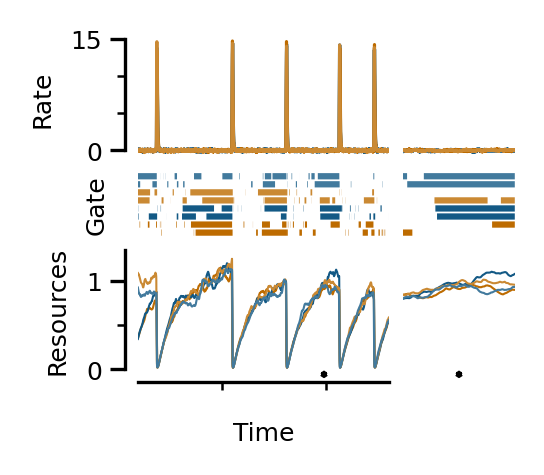

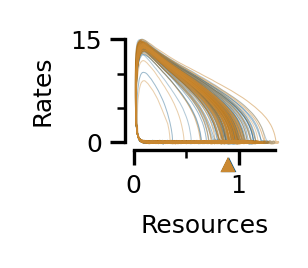

In [2]:
pp.log.setLevel("INFO")
pp.show_title = False
pp.show_ylabel = True
pp.show_xlabel = True
# tweak some of the parameters and get a quick-and-dirty representation of the run
figs = pp.meso_explore(
    # kwargs are passed through to the `mm.simulate_model`
    simulation_time=10000,
    ext_str=[0.0, 0.0, 0.0, 0.0],
    # ext_str=[0.125, 0.0, 0.125, 0.0],
    w0=0.1,
    gating_mechanism=True,
    range_to_show=[50, 650],
    zoom_start=470,
    rseed=42,
);
figs[0].savefig(f"{pp.p_fo}/meso_explore.pdf", dpi=900)
figs[1].savefig(f"{pp.p_fo}/meso_explore_cycle.pdf", dpi=300)

## Generating Data

Simulations of the mesoscopic model are pretty fast, and can be run in a few minutes on a laptop.

We have the `run/meso_launcher.py` script that uses the model from above, and creates output files in `dat/simulations/meso/raw` or `raw_long_ts` (see the script file for details).

To analyse:

In [35]:
# for the phase plots, short time series are sufficient.
# we created longer ones for plotting resource cycles.
dset = mh.process_data_from_folder(f"{pp.p_sim}/meso/raw_partial_gates_on")
mh.write_xr_dset_to_hdf5(dset, output_path=f"{pp.p_sim}/meso/processed/analysed_gates_on.hdf5")
dset = mh.process_data_from_folder(f"{pp.p_sim}/meso/raw_partial_gates_off")
mh.write_xr_dset_to_hdf5(dset, output_path=f"{pp.p_sim}/meso/processed/analysed_gates_off.hdf5")

analysing files: 100%|██████████| 5200/5200 [09:44<00:00,  8.89it/s]


## Plots from the paper

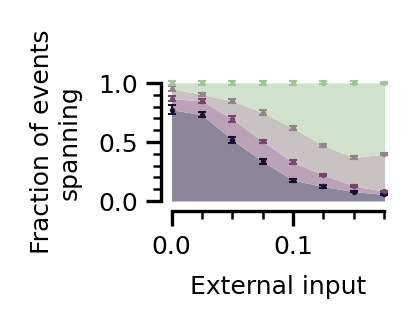

In [5]:
# fig 4 module contribution

pp.show_xlabel=True
pp.show_ylabel=True

case = "_gates_on"
# case = "_gates_off"

ax = pp.sim_modules_participating_in_bursts(
    f"{pp.p_sim}/meso/processed/analysed{case}.hdf5",
    simulation_coordinates=dict(coupling=0.1),
    xlim_for_fill=[0, 0.2],
    xlim_for_points=[0, 0.176],
    dim1="noise",
    drop_zero_len=False,
)
ax.set_xlabel("External input" if pp.show_xlabel else "")
ax.set_ylabel("Fraction of events\nspanning" if pp.show_ylabel else "")

ax.xaxis.set_major_locator(pp.matplotlib.ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(pp.matplotlib.ticker.MultipleLocator(0.025))

ax.set_xlim(0, 0.175)

pp.sns.despine(ax=ax, offset=2.5)
pp.cc.set_size(ax, w=1.8, h=1.0, l=0.8, b=0.5, r=0.2, t=0.2)

ax.get_figure().savefig(f"{pp.p_fo}/meso_partial{case}_modules_participating_in_bursts.pdf", dpi=300)

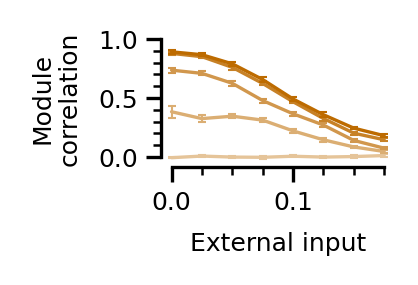

In [6]:
case = "_gates_on"
# case = "_gates_off"

pp.log.setLevel("INFO")
pp.show_xlabel = True
pp.show_ylabel = True
pp.show_title = False
pp.show_legend = False


dset = pp.nh.load_ndim_h5f(f"{pp.p_sim}/meso/processed/analysed{case}.hdf5")
dset = dset.where(dset["noise"] < 0.2)
cc = pp.cc

ax = None
for kdx, c in enumerate([0.0, 0.03, 0.05, 0.1, 0.15]):
    coords = dict()
    coords["coupling"] = c
    ax = pp.sim_plot_obs_from_ndim(
        dset = dset,
        coords = coords,
        observable = "median_correlation_coefficient_within_stim",
        x_dim = "noise",
        ax = ax,
        errortype="sem",
        estimator="mean",
        color= cc.alpha_to_solid_on_bg(pp.colors["stim"], cc.fade(kdx, 5, invert=True)),
        clip_on=False,
    )

ax.set_xlim(0, 0.175)
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(pp.matplotlib.ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(pp.matplotlib.ticker.MultipleLocator(0.025))
ax.yaxis.set_major_locator(pp.matplotlib.ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(pp.matplotlib.ticker.MultipleLocator(0.1))

ax.set_xlabel("External input" if pp.show_xlabel else "")
ax.set_ylabel("Module\ncorrelation" if pp.show_ylabel else "")

pp.sns.despine(ax=ax, offset=2.5)
pp.cc.set_size(ax, w=1.8, h=1.0, l=0.8, b=0.5, r=0.2, t=0.2)
ax.get_figure().savefig(f"{pp.p_fo}/f4_meso_correlation_vs_rate.pdf", dpi=300)



## Interplay of noise and external input for individual modules


    Creates Suppl. Fig S7, exploring single-module dynamics in the mesoscopic model.

    * 3 panels showing the stationary (infinite time) solutions in different planes.
        - inputs go from low (blue) to medium (yellow) to high (red)
    * Matrix of flow fields
        - for increasting input strength h (left to right, matching colors from above)
        - and increasing noise intensity sigma (top to bottom)
        - gray lines indicate the trajectory a single module would _determinsitically_
            follow if placed at a given position in phase space
        - colored lines indicate actual trajectories, when the module is exposed
            to permutations due to the noise.
    


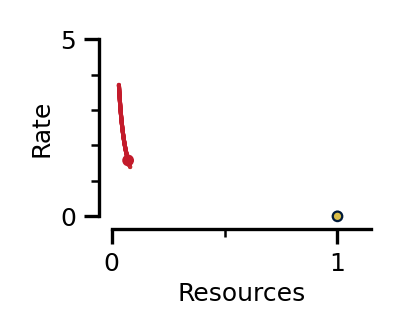

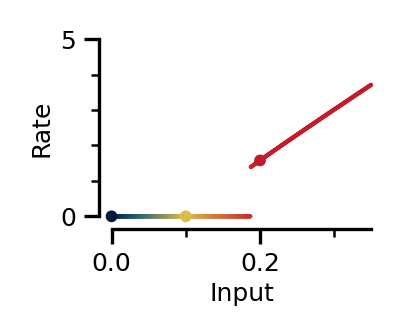

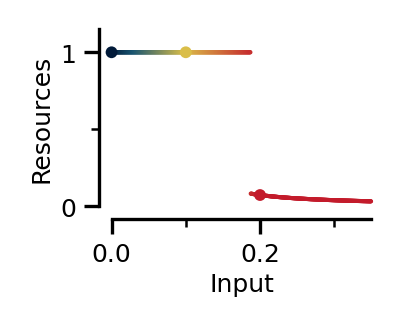

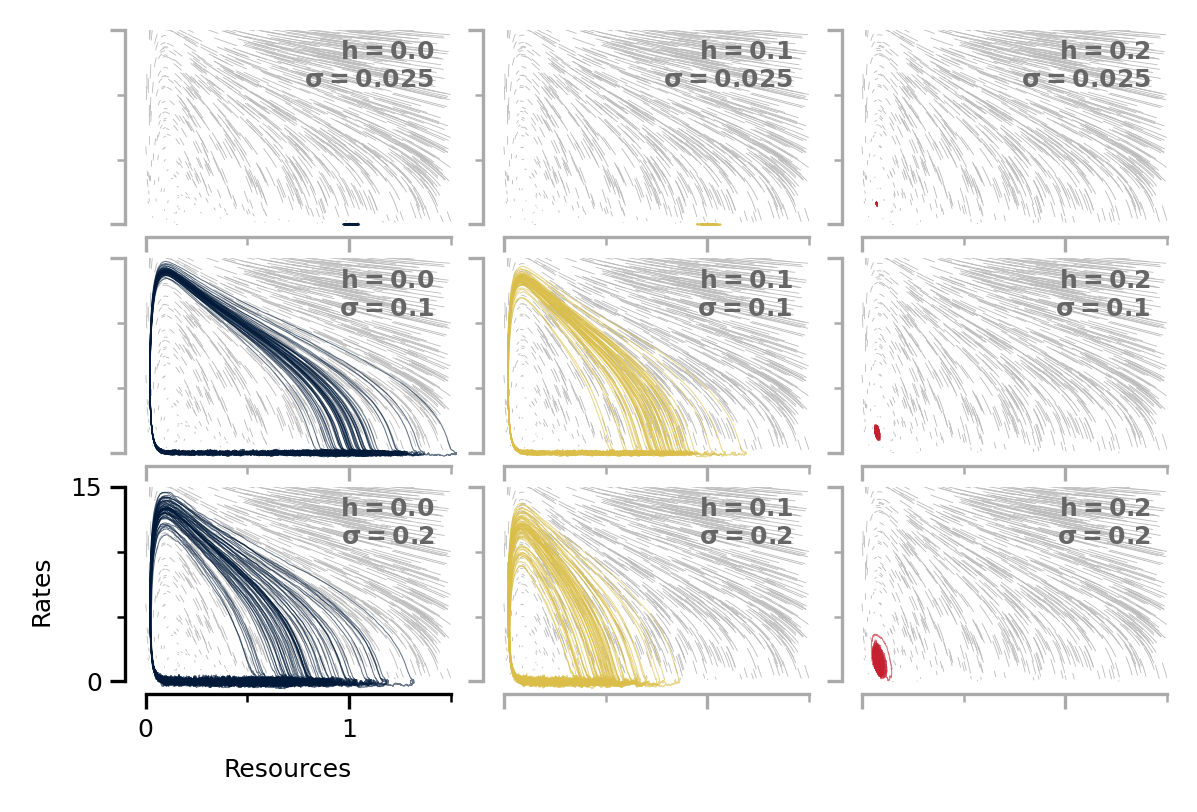

In [10]:
# unaltered in Rev 1, single-module dynamics

print(pp.fig_sm_meso_noise_and_input_flowfields.__doc__)
pp.fig_sm_meso_noise_and_input_flowfields()

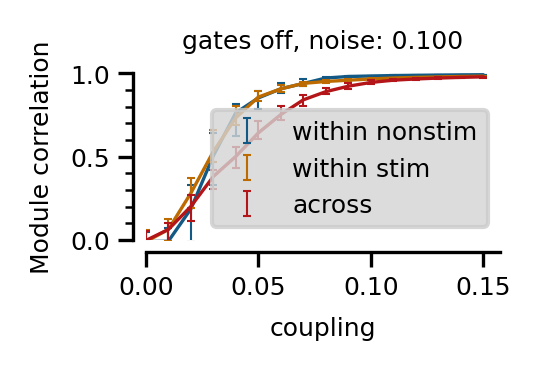

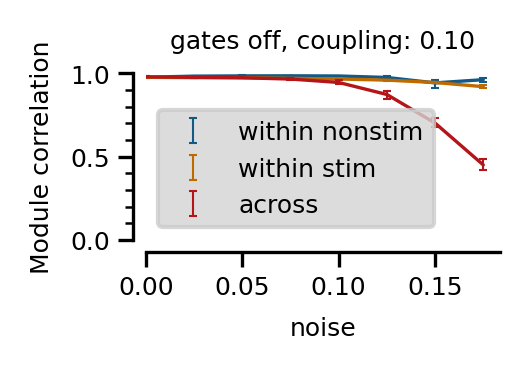

In [19]:
# Observables as a function of either coupling or noise,
# not used in the manuscript. Like Fig 3, but for mesoscopic model.

# To get the version with gates disabled, manually provide the right
# file paths / loaded dset
# print(pp.fig_5.__doc__)
pp.log.setLevel("INFO")
pp.show_legend = True
pp.show_title = True
# case = "_gates_off"
case = "_gates_off"
axes = pp.fig_correlation_vs_noise_and_coupling(
    dset=f"{pp.p_sim}/meso/processed/analysed{case}.hdf5",
    out_path=f"{pp.p_fo}/meso_partial{case}",
)

# ax.set_xscale("log")
# ax.set_xlim(1e-2, 1)